# Evaluation

### In this notebook we will use different metrics to evaluate the different models we created
**In particular we are going to evaluate:**
- The plain **RNN** and the **Wait-k RNN** trained on the vocabulary of the two texts
- The plain **RNN** and the **Wait-k RNN** trained on the enronsent dataset
- Our naive approach

### We are goint to work with the two sentences:
- Thank your message to show our words to the doctor, as his next contract checking, to all of us.
- Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets.
### The ground truth for these two is:
- Thank you for forwarding our remarks to the doctor for his upcoming contract review on behalf of all of us.
- First, let’s confirm everyone’s safety; afterward, we’ll celebrate the result with a strong coffee and set new goals for the future.
### The code for the naive approach:

In [1]:
def tokenize(sentence):
    tokens = []
    word = ""
    for char in sentence:
        if char.isalnum():
            word += char
        else:
            if word:
                tokens.append(word.lower())  # Case-insensitive
                word = ""
            if char.strip():  # Non-whitespace
                tokens.append(char)
    if word:
        tokens.append(word.lower())
    return tokens

pos_dict = {
    "thank": "V", "your": "PRON", "message": "N", "to": "PREP", "show": "V",
    "our": "PRON", "words": "N", "the": "DET", "doctor": "N", "as": "PREP",
    "his": "PRON", "next": "ADJ", "contract": "N", "checking": "V", "all": "DET",
    "of": "PREP", "us": "PRON", "overall": "ADV", "let": "V", "make": "V",
    "sure": "ADJ", "are": "V", "safe": "ADJ", "and": "CONJ", "celebrate": "V",
    "outcome": "N", "with": "PREP", "strong": "ADJ", "coffee": "N", "future": "ADJ",
    "targets": "N", ",": "PUNCT", ".": "PUNCT"
}
verbs = {word for word, tag in pos_dict.items() if tag == "V"}

def tag(tokens):
    tagged = [(token, pos_dict.get(token, "UNK")) for token in tokens]
    for i in range(len(tagged) - 1):
        if tagged[i][0] == "to":
            tagged[i] = ("to", "TO" if tagged[i+1][1] == "V" else "PREP")
    return tagged

rules = [
    # Rule 1: Insert "you" after "thank"
    (
        [("thank", "V")],
        [("thank", "V"), ("you", "PRON")]
    ),
    # Rule 2: Insert "for" before "your message"
    (
        [("you", "PRON"), ("your", "PRON"), ("message", "N")],
        [("you", "PRON"), ("for", "PREP"), ("your", "PRON"), ("message", "N")]
    ),
    # Rule 3: Replace "as" with "during"
    (
        [("as", "PREP")],
        [("during", "PREP")]
    ),
    # Rule 4: Replace "checking" with "review"
    (
        [("checking", "V")],
        [("review", "N")]
    )
]

def apply_rules(tagged):
    for pattern, replacement in rules:
        pattern_len = len(pattern)
        for i in range(len(tagged) - pattern_len + 1):
            if tagged[i:i+pattern_len] == pattern:
                tagged = tagged[:i] + replacement + tagged[i+pattern_len:]
                break  # Apply each rule once per pattern
    return tagged

def reconstruct(tagged):
    tokens = [word for word, _ in tagged]
    sentence = " ".join(tokens)
    for punct in [",", ".", "!", "?", ";", ":"]:
        sentence = sentence.replace(" " + punct, punct)
    return sentence[0].upper() + sentence[1:]  # Capitalize first letter

def process_sentence(sentence):
    tokens = tokenize(sentence)
    tagged = tag(tokens)
    transformed = apply_rules(tagged)
    reconstructed = reconstruct(transformed)
    return reconstructed

# Test the pipeline
sentence1 = "Thank your message to show our words to the doctor, as his next contract checking, to all of us."
sentence2 = "Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets."

naive_reconstructed_1 = process_sentence(sentence1)
naive_reconstructed_2 = process_sentence(sentence2)

# get the reconstructed sentences into a tex file
with open("reconstructed_sentences.txt", "w") as f:
    f.write(naive_reconstructed_1 + "\n")
    f.write(naive_reconstructed_2 + "\n")

## The code for the neural networks that are trained on the original vocabulary


In [2]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import ast

# --- 1) Load raw vocab.csv (columns: 'primary', 'secondary') and flatten all tokens ---
vocab_df = pd.read_csv('try1/data/vocab.csv')
raw_tokens = set()

for col in ['primary', 'secondary']:
    for cell in vocab_df[col].dropna():
        # each cell is a string like "['and','but',...']"
        try:
            lst = ast.literal_eval(cell)
            if isinstance(lst, list):
                raw_tokens.update(lst)
        except Exception:
            pass

# --- 1a) Define & prepend special tokens ---
specials = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
# Ensure no overlap:
for s in specials:
    raw_tokens.discard(s)

# Final ordered vocab: specials first, then sorted rest
all_tokens = specials + sorted(raw_tokens)

# --- 1b) Rebuild mappings from scratch ---
word2index = {tok: idx for idx, tok in enumerate(all_tokens)}
index2word = {idx: tok for tok, idx in word2index.items()}
vocab_size = len(all_tokens)

print(f"Prepended specials: {specials}")
print(f"Total unique tokens from CSV: {len(raw_tokens)}")
print(f"New vocab size = {vocab_size}")

# --- 2) Simple tokenizer: keeps alphanumeric + underscore tokens together,
#    splits off punctuation.
def tokenize(text):
    tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)
    return [t.lower() for t in tokens]




# --- 1) Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 2) Model definitions (reuse classes you already have) ---
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
    def forward(self, x):
        emb = self.embedding(x)                    # (B, L_in, E)
        outputs, hidden = self.lstm(emb)           # outputs=(B,L_in,H), hidden=(h_n,c_n)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.out  = nn.Linear(hidden_size*2, vocab_size)
    def forward_step(self, prev_tok, hidden, enc_outputs):
        emb = self.embedding(prev_tok).unsqueeze(1)     # (B,1,E)
        out, hidden = self.lstm(emb, hidden)            # out=(B,1,H)
        # dot-product attention
        scores = torch.bmm(out, enc_outputs.transpose(1,2))  # (B,1,L_in)
        attn  = torch.softmax(scores, dim=2)                # (B,1,L_in)
        ctx   = torch.bmm(attn, enc_outputs).squeeze(1)     # (B,H)
        out_t = out.squeeze(1)                              # (B,H)
        cat   = torch.cat([out_t, ctx], dim=1)              # (B,2H)
        logits= self.out(cat)                               # (B,V)
        return logits, hidden, attn


# load decoder_final and encoder_final
embed_size = 300
hidden_size = 256
encoder = Encoder(vocab_size, embed_size, hidden_size)
decoder = Decoder(vocab_size, embed_size, hidden_size)
encoder.load_state_dict(torch.load('try1/models/encoder_final.pt', map_location=device))
decoder.load_state_dict(torch.load('try1/models/decoder_final.pt', map_location=device))
encoder.to(device)
decoder.to(device)
special_tokens = {'<PAD>','<SOS>','<EOS>','<UNK>'}
def generate(sentence, max_len=50):
    """
    1) Masks out specials so the model never picks them.
    2) If it still outputs <UNK>, we use the attention weights
       to pick the source token it was “looking at” most.
    3) We filter out any <SOS> or <PAD> in the final list.
    """
    encoder.eval()
    decoder.eval()
    # tokenize & indices
    src_tokens = tokenize(sentence)
    src_ids    = [word2index.get(w, word2index['<UNK>']) for w in src_tokens]
    inp        = torch.tensor(src_ids, device=device).unsqueeze(0)
    # encode
    enc_out, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    # start decoding
    dec_input  = torch.tensor([word2index['<SOS>']], device=device)
    out_tokens = []
    
    for _ in range(max_len):
        # get logits and attention
        logits, dec_hidden, attn = decoder.forward_step(dec_input, dec_hidden, enc_out)
        # mask out specials so they have zero probability
        for sp in ['<PAD>','<SOS>','<UNK>']:
            logits[:, word2index[sp]] = -1e9
        # pick next
        next_id = logits.argmax(dim=1).item()
        if next_id == word2index['<EOS>']:
            break
        
        tok = index2word[next_id]
        # if it’s still <UNK>, copy from source via attention
        if tok == '<UNK>':
            # attn shape is (1,1,src_len)
            a = attn.squeeze(0).squeeze(0)          # (src_len,)
            src_pos = a.argmax().item()
            tok = src_tokens[src_pos]
        
        # only keep real tokens
        if tok not in special_tokens:
            out_tokens.append(tok)
        
        dec_input = torch.tensor([next_id], device=device)
    
    return " ".join(out_tokens)

vocab_rnn_plain_1 = generate(sentence1)
vocab_rnn_plain_2 = generate(sentence2)


Prepended specials: ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
Total unique tokens from CSV: 483
New vocab size = 487
Using device: cpu


### And for the wait-k approach

In [3]:
import re
import torch
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tokenize(text):
    tokens = re.findall(r"\w+|[^\w\s]", text, flags=re.UNICODE)
    return [t.lower() for t in tokens]


# --- 1) Load raw vocab.csv (columns: 'primary', 'secondary') and flatten all tokens ---
vocab_df = pd.read_csv('try1/data/vocab.csv')
raw_tokens = set()

for col in ['primary', 'secondary']:
    for cell in vocab_df[col].dropna():
        # each cell is a string like "['and','but',...']"
        try:
            lst = ast.literal_eval(cell)
            if isinstance(lst, list):
                raw_tokens.update(lst)
        except Exception:
            pass

# --- 1a) Define & prepend special tokens ---
specials = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
# Ensure no overlap:
for s in specials:
    raw_tokens.discard(s)

# Final ordered vocab: specials first, then sorted rest
all_tokens = specials + sorted(raw_tokens)

# --- 1b) Rebuild mappings from scratch ---
word2index = {tok: idx for idx, tok in enumerate(all_tokens)}
index2word = {idx: tok for tok, idx in word2index.items()}
vocab_size = len(all_tokens)

print(f"Prepended specials: {specials}")
print(f"Total unique tokens from CSV: {len(raw_tokens)}")
print(f"New vocab size = {vocab_size}")



# --- 9) Model definition ---
# --- 1) Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 1) Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- 2) Model definitions (reuse classes you already have) ---
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
    def forward(self, x):
        emb = self.embedding(x)                    # (B, L_in, E)
        outputs, hidden = self.lstm(emb)           # outputs=(B,L_in,H), hidden=(h_n,c_n)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.out  = nn.Linear(hidden_size*2, vocab_size)
    def forward_step(self, prev_tok, hidden, enc_outputs):
        emb = self.embedding(prev_tok).unsqueeze(1)     # (B,1,E)
        out, hidden = self.lstm(emb, hidden)            # out=(B,1,H)
        # dot-product attention
        scores = torch.bmm(out, enc_outputs.transpose(1,2))  # (B,1,L_in)
        attn  = torch.softmax(scores, dim=2)                # (B,1,L_in)
        ctx   = torch.bmm(attn, enc_outputs).squeeze(1)     # (B,H)
        out_t = out.squeeze(1)                              # (B,H)
        cat   = torch.cat([out_t, ctx], dim=1)              # (B,2H)
        logits= self.out(cat)                               # (B,V)
        return logits, hidden, attn



embed_size = 400
hidden_size = 128
special_tokens = {'<PAD>','<SOS>','<EOS>','<UNK>'}
# load the encoder and decoder models from the models directory
encoder = Encoder(vocab_size, embed_size, hidden_size).to(device)
decoder = Decoder(vocab_size, embed_size, hidden_size).to(device)
encoder.load_state_dict(torch.load('try1/models/encoder_2.pth'))
decoder.load_state_dict(torch.load('try1/models/decoder_2.pth'))

def translate_wait_k(src_sentence, K, max_len=50):
    encoder.eval(); decoder.eval()
    src_toks = tokenize(src_sentence)
    src_ids  = [ word2index.get(t, word2index['<UNK>']) for t in src_toks ]
    outputs = []
    t = 1
    while True:
        r = min(K + (t-1), len(src_ids))
        inp = torch.tensor(src_ids[:r], device=device).unsqueeze(0)
        enc_out, enc_hidden = encoder(inp)
        prev_id = word2index['<SOS>'] if t == 1 else outputs[-1]
        logits, dec_hidden, attn = decoder.forward_step(
            torch.tensor([prev_id], device=device), enc_hidden, enc_out
        )
        # mask specials
        for sp in special_tokens - {'<EOS>'}:
            logits[:, word2index[sp]] = -1e9
        next_id = logits.argmax(dim=1).item()
        if next_id == word2index['<EOS>'] or t >= max_len:
            break
        tok = index2word[next_id]
        # copy from source if UNK
        if tok == '<UNK>':
            a = attn.squeeze(0).squeeze(0)
            src_pos = a.argmax().item()
            tok = src_toks[src_pos]
            next_id = word2index.get(tok, next_id)
        if tok not in special_tokens:
            outputs.append(next_id)
        else:
            outputs.append(next_id)
        t += 1

    return " ".join(index2word[i] for i in outputs)

# Sample usage:
vocab_rnn_wait_1 = translate_wait_k(sentence1, K=2, max_len=len(sentence1.split())+10)
vocab_rnn_wait_2 = translate_wait_k(sentence2, K=2, max_len=len(sentence2.split())+10)




Prepended specials: ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
Total unique tokens from CSV: 483
New vocab size = 487
Using device: cpu
Using device: cpu


### And for the enronsent trained RNNs

In [4]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import ast

# --- 1) Load & parse original‐texts vocab (has 'tokens', 'frequency', 'examples') ---
orig_df = pd.read_csv('try2/data/vocab_lookup_original_texts.csv')
raw_tokens = set()
for cell in orig_df['tokens'].dropna():
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            raw_tokens.update(tok.lower() for tok in lst)
    except Exception:
        pass  # skip malformed

# --- 2) Load & parse new dataset vocab (has 'token', 'lemma', 'pos') ---
new_df = pd.read_csv('try2/data/new_vocab_lookup.csv')
raw_tokens.update(tok.lower() for tok in new_df['token'].dropna().astype(str))

# --- 3) Define special tokens & ensure no duplicates ---
specials = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
for s in specials:
    raw_tokens.discard(s)

# --- 4) Build final ordered vocab & mappings ---
all_tokens  = specials + sorted(raw_tokens)
word2index  = {tok: idx for idx, tok in enumerate(all_tokens)}
index2word  = {idx: tok for tok, idx in word2index.items()}
vocab_size  = len(all_tokens)

# load decoder_final and encoder_final
embed_size = 128
hidden_size = 256
encoder = Encoder(vocab_size, embed_size, hidden_size)
decoder = Decoder(vocab_size, embed_size, hidden_size)
encoder.load_state_dict(torch.load('try2/models/encoder_final.pt', map_location=device))
decoder.load_state_dict(torch.load('try2/models/decoder_final.pt', map_location=device))
encoder.to(device)
decoder.to(device)
special_tokens = {'<PAD>','<SOS>','<EOS>','<UNK>'}
def generate(sentence, max_len=50):
    """
    1) Masks out specials so the model never picks them.
    2) If it still outputs <UNK>, we use the attention weights
       to pick the source token it was “looking at” most.
    3) We filter out any <SOS> or <PAD> in the final list.
    """
    encoder.eval()
    decoder.eval()
    # tokenize & indices
    src_tokens = tokenize(sentence)
    src_ids    = [word2index.get(w, word2index['<UNK>']) for w in src_tokens]
    inp        = torch.tensor(src_ids, device=device).unsqueeze(0)
    # encode
    enc_out, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    # start decoding
    dec_input  = torch.tensor([word2index['<SOS>']], device=device)
    out_tokens = []
    
    for _ in range(max_len):
        # get logits and attention
        logits, dec_hidden, attn = decoder.forward_step(dec_input, dec_hidden, enc_out)
        # mask out specials so they have zero probability
        for sp in ['<PAD>','<SOS>','<UNK>']:
            logits[:, word2index[sp]] = -1e9
        # pick next
        next_id = logits.argmax(dim=1).item()
        if next_id == word2index['<EOS>']:
            break
        
        tok = index2word[next_id]
        # if it’s still <UNK>, copy from source via attention
        if tok == '<UNK>':
            # attn shape is (1,1,src_len)
            a = attn.squeeze(0).squeeze(0)          # (src_len,)
            src_pos = a.argmax().item()
            tok = src_tokens[src_pos]
        
        # only keep real tokens
        if tok not in special_tokens:
            out_tokens.append(tok)
        
        dec_input = torch.tensor([next_id], device=device)
    
    return " ".join(out_tokens)

enronsent_rnn_plain_1 = generate(sentence1)
enronsent_rnn_plain_2 = generate(sentence2)



In [5]:
import re
import torch
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tokenize(sentence):
    # Split by any whitespace or punctuation, keeping punctuation as separate tokens.
    tokens = re.findall(r"\w+|[^\w\s]", sentence, flags=re.UNICODE)
    return [tok.lower() for tok in tokens]


# --- 1) Load & parse original‐texts vocab (has 'tokens', 'frequency', 'examples') ---
orig_df = pd.read_csv('try2/data/vocab_lookup_original_texts.csv')
raw_tokens = set()
for cell in orig_df['tokens'].dropna():
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            raw_tokens.update(tok.lower() for tok in lst)
    except Exception:
        pass  # skip malformed

# --- 2) Load & parse new dataset vocab (has 'token', 'lemma', 'pos') ---
new_df = pd.read_csv('try2/data/new_vocab_lookup.csv')
raw_tokens.update(tok.lower() for tok in new_df['token'].dropna().astype(str))

# --- 3) Define special tokens & ensure no duplicates ---
specials = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
for s in specials:
    raw_tokens.discard(s)

# --- 4) Build final ordered vocab & mappings ---
all_tokens  = specials + sorted(raw_tokens)
word2index  = {tok: idx for idx, tok in enumerate(all_tokens)}
index2word  = {idx: tok for tok, idx in word2index.items()}
vocab_size  = len(all_tokens)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        emb = self.embedding(x)                    # (B, L_in, E)
        outputs, hidden = self.lstm(emb)           # outputs=(B,L_in,H), hidden=(h_n,c_n)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=word2index['<PAD>'])
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.out  = nn.Linear(hidden_size*2, vocab_size)

    def forward_step(self, prev_tok, hidden, enc_outputs):
        emb = self.embedding(prev_tok).unsqueeze(1)     # (B,1,E)
        out, hidden = self.lstm(emb, hidden)            # out=(B,1,H)
        # dot-product attention
        scores = torch.bmm(out, enc_outputs.transpose(1,2))  # (B,1,L_in)
        attn  = torch.softmax(scores, dim=2)                # (B,1,L_in)
        ctx   = torch.bmm(attn, enc_outputs).squeeze(1)     # (B,H)
        out_t = out.squeeze(1)                              # (B,H)
        cat   = torch.cat([out_t, ctx], dim=1)              # (B,2H)
        logits= self.out(cat)                               # (B,V)
        return logits, hidden, attn
    
special_tokens = {'<PAD>','<SOS>','<EOS>','<UNK>'}
# load the encoder and decoder models from the models directory
# 1) Hyperparameters (reuse or override)
embed_size = 512
hidden_size = 512
num_layers = 2

encoder = Encoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
encoder.load_state_dict(torch.load('try2/models/encoder_2.pth', map_location=device))
decoder.load_state_dict(torch.load('try2/models/decoder_2.pth', map_location=device))

def translate_wait_k(src_sentence, K, max_len=50):
    encoder.eval(); decoder.eval()
    src_toks = tokenize(src_sentence)
    src_ids  = [ word2index.get(t, word2index['<UNK>']) for t in src_toks ]
    outputs = []
    t = 1
    while True:
        r = min(K + (t-1), len(src_ids))
        inp = torch.tensor(src_ids[:r], device=device).unsqueeze(0)
        enc_out, enc_hidden = encoder(inp)
        prev_id = word2index['<SOS>'] if t == 1 else outputs[-1]
        logits, dec_hidden, attn = decoder.forward_step(
            torch.tensor([prev_id], device=device), enc_hidden, enc_out
        )
        # mask specials
        for sp in special_tokens - {'<EOS>'}:
            logits[:, word2index[sp]] = -1e9
        next_id = logits.argmax(dim=1).item()
        if next_id == word2index['<EOS>'] or t >= max_len:
            break
        tok = index2word[next_id]
        # copy from source if UNK
        if tok == '<UNK>':
            a = attn.squeeze(0).squeeze(0)
            src_pos = a.argmax().item()
            tok = src_toks[src_pos]
            next_id = word2index.get(tok, next_id)
        if tok not in special_tokens:
            outputs.append(next_id)
        else:
            outputs.append(next_id)
        t += 1

    return " ".join(index2word[i] for i in outputs)

enronsent_rnn_wait_1 = translate_wait_k(sentence1, K=2, max_len=len(sentence1.split())+10)
enronsent_rnn_wait_2 = translate_wait_k(sentence2, K=2, max_len=len(sentence2.split())+10)

Using device: cpu


In [6]:
gt1 = "Thank you for forwarding our remarks to the doctor for his upcoming contract review on behalf of all of us."
gt2 = "First, let’s confirm everyone’s safety; afterward, we’ll celebrate the result with a strong coffee and set new goals for the future."

# To compare the results with that **ground truth** we are going to use the following metrics:
### Token-Level Precision / Recall / F₁ (Overlap)

Let  
- $m$ = number of matching tokens between the candidate and the reference  
- $\lvert\text{cand}\rvert$ = number of tokens in the candidate  
- $\lvert\text{ref}\rvert$ = number of tokens in the reference  

Then:

- **Precision**  
  $$
    P = \frac{m}{\lvert\text{cand}\rvert}
  $$

- **Recall**  
  $$
    R = \frac{m}{\lvert\text{ref}\rvert}
  $$

- **F₁ Score**  
  $$
    F_{1} = \frac{2 \, P \, R}{P + R}
  $$

---

### Word Error Rate (WER)

Let  
- $S$ = number of substitutions  
- $D$ = number of deletions  
- $I$ = number of insertions  
- $N$ = total number of words in the reference  

Then the word error rate is  
$$
  \text{WER} = \frac{S + D + I}{N}
$$

---

### BERTScore

Given contextual token embeddings $\mathbf{e}(\cdot)$ for each token, define:

- **Precision**  
  $$
    P_{\text{BERT}} = \frac{1}{\lvert\text{cand}\rvert}
      \sum_{j=1}^{\lvert\text{cand}\rvert}
      \max_{i}\,\cos\bigl(\mathbf{e}(\text{ref}_i),\,\mathbf{e}(\text{cand}_j)\bigr)
  $$

- **Recall**  
  $$
    R_{\text{BERT}} = \frac{1}{\lvert\text{ref}\rvert}
      \sum_{i=1}^{\lvert\text{ref}\rvert}
      \max_{j}\,\cos\bigl(\mathbf{e}(\text{ref}_i),\,\mathbf{e}(\text{cand}_j)\bigr)
  $$

- **F₁ Score**  
  $$
    F_{\text{BERT}} = \frac{2 \, P_{\text{BERT}} \, R_{\text{BERT}}}
                        {P_{\text{BERT}} + R_{\text{BERT}}}
  $$

---

### Sentence Embedding Cosine (e.g., SBERT, USE)

Given a sentence embedding model that maps each sentence $s$ to a vector $\mathbf{e}(s)$:

$$
  \text{sim}_{\text{sent}}(c, r)
  = \frac{\mathbf{e}(c)\cdot \mathbf{e}(r)}
         {\|\mathbf{e}(c)\|\,\|\mathbf{e}(r)\|}
$$

where “$\cdot$” is the dot product and $\|\cdot\|$ is the Euclidean norm.

---

### Plain Cosine Similarity (Token-Level)

Representing each sentence as a bag-of-tokens vector $\mathbf{v}_{c}$, $\mathbf{v}_{r}$ (e.g., TF or TF-IDF):

$$
  \cos(\mathbf{v}_c, \mathbf{v}_r)
  = \frac{\mathbf{v}_c \cdot \mathbf{v}_r}
         {\|\mathbf{v}_c\|\,\|\mathbf{v}_r\|}
$$


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\claza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Robe

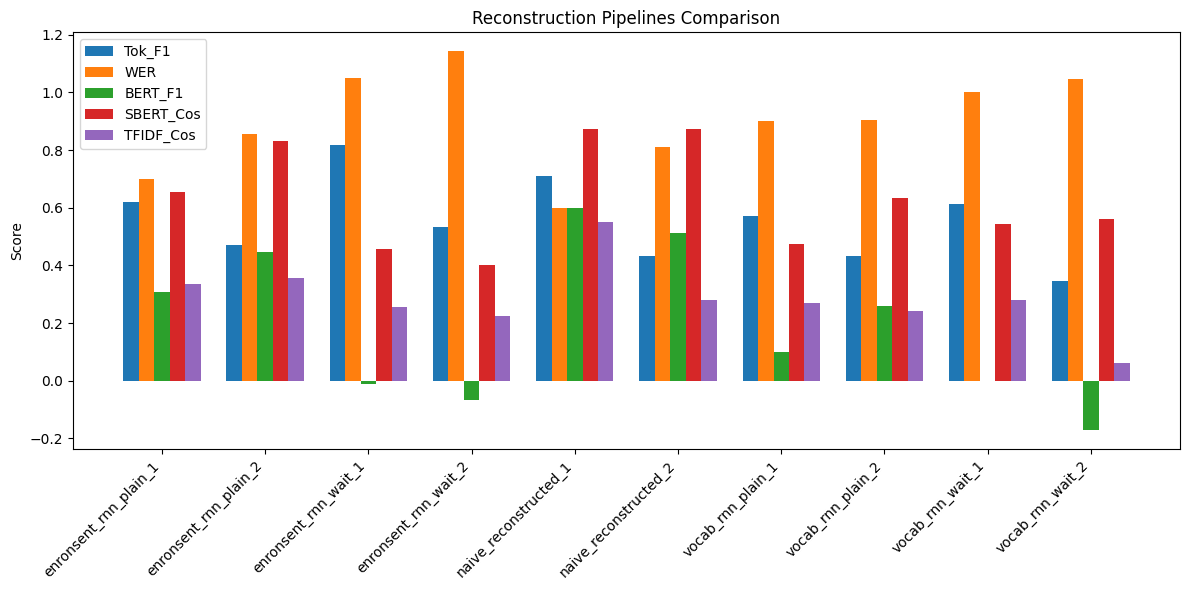

In [7]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jiwer import wer
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
import os, pathlib
pathlib.Path("tables").mkdir(exist_ok=True)


def ensure_list(x):
    """Wrap in list if x is a single string."""
    return x if isinstance(x, list) else [x]




# ensure every one is a list
vars_raw = {
    'gt1': gt1, 'gt2': gt2,
    'enronsent_rnn_wait_1': enronsent_rnn_wait_1,
    'enronsent_rnn_wait_2': enronsent_rnn_wait_2,
    'enronsent_rnn_plain_1': enronsent_rnn_plain_1,
    'enronsent_rnn_plain_2': enronsent_rnn_plain_2,
    'vocab_rnn_wait_1': vocab_rnn_wait_1,
    'vocab_rnn_wait_2': vocab_rnn_wait_2,
    'vocab_rnn_plain_1': vocab_rnn_plain_1,
    'vocab_rnn_plain_2': vocab_rnn_plain_2,
    'naive_reconstructed_1': naive_reconstructed_1,
    'naive_reconstructed_2': naive_reconstructed_2,
}
vars_lists = {k: ensure_list(v) for k, v in vars_raw.items()}

# 1. Metric functions

def token_prf(cand: str, ref: str):
    cand_toks = nltk.word_tokenize(cand)
    ref_toks  = nltk.word_tokenize(ref)
    if not cand_toks or not ref_toks:
        return 0.0, 0.0, 0.0
    matches = sum(1 for t in cand_toks if t in ref_toks)
    P = matches / len(cand_toks)
    R = matches / len(ref_toks)
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0
    return P, R, F1

def wer_score(cand: str, ref: str):
    return wer(ref, cand)

sbert = SentenceTransformer('all-MiniLM-L6-v2')
def sbert_cosine(cand: str, ref: str):
    emb_c = sbert.encode(cand, convert_to_tensor=True)
    emb_r = sbert.encode(ref, convert_to_tensor=True)
    return util.pytorch_cos_sim(emb_c, emb_r).item()

# build a corpus for TF-IDF
all_texts = []
for lst in vars_lists.values():
    all_texts += lst

tfidf = TfidfVectorizer().fit(all_texts)
def tfidf_cosine(cand: str, ref: str):
    v = tfidf.transform([cand, ref])
    return cosine_similarity(v[0], v[1])[0,0]

# 2. Aggregate over pipelines
pipelines = [
    ('enronsent_rnn_wait', 
        vars_lists['enronsent_rnn_wait_1'], vars_lists['enronsent_rnn_wait_2']),
    ('enronsent_rnn_plain',
        vars_lists['enronsent_rnn_plain_1'], vars_lists['enronsent_rnn_plain_2']),
    ('vocab_rnn_wait',
        vars_lists['vocab_rnn_wait_1'], vars_lists['vocab_rnn_wait_2']),
    ('vocab_rnn_plain',
        vars_lists['vocab_rnn_plain_1'], vars_lists['vocab_rnn_plain_2']),
    ('naive_reconstructed',
        vars_lists['naive_reconstructed_1'], vars_lists['naive_reconstructed_2']),
]

records = []
for name, gen1, gen2 in pipelines:
    for idx, (cand, ref) in enumerate(zip(gen1, vars_lists['gt1']), start=1):
        p, r, f1 = token_prf(cand, ref)
        w = wer_score(cand, ref)
        _, _, fb1 = bert_score([cand], [ref], lang='en', rescale_with_baseline=True)
        sb = sbert_cosine(cand, ref)
        tc = tfidf_cosine(cand, ref)
        records.append({
            'Pipeline': f"{name}_1",
            'Instance': idx,
            'Tok_Prec': p, 'Tok_Rec': r, 'Tok_F1': f1,
            'WER': w,
            'BERT_F1': fb1.item(),
            'SBERT_Cos': sb,
            'TFIDF_Cos': tc,
        })
    for idx, (cand, ref) in enumerate(zip(gen2, vars_lists['gt2']), start=1):
        p, r, f1 = token_prf(cand, ref)
        w = wer_score(cand, ref)
        _, _, fb2 = bert_score([cand], [ref], lang='en', rescale_with_baseline=True)
        sb = sbert_cosine(cand, ref)
        tc = tfidf_cosine(cand, ref)
        records.append({
            'Pipeline': f"{name}_2",
            'Instance': idx,
            'Tok_Prec': p, 'Tok_Rec': r, 'Tok_F1': f1,
            'WER': w,
            'BERT_F1': fb2.item(),
            'SBERT_Cos': sb,
            'TFIDF_Cos': tc,
        })

df = pd.DataFrame(records)
summary = df.groupby('Pipeline').mean().reset_index()

# 3. Visualization
metrics = ['Tok_F1', 'WER', 'BERT_F1', 'SBERT_Cos', 'TFIDF_Cos']
x = np.arange(len(summary))
width = 0.15

plt.figure(figsize=(12, 6))
for i, m in enumerate(metrics):
    plt.bar(x + i*width, summary[m], width, label=m)
plt.xticks(x + width*(len(metrics)-1)/2, summary['Pipeline'], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Reconstruction Pipelines Comparison')
plt.legend()
plt.tight_layout()
plt.show()


summary.set_index('Pipeline')[metrics].round(2).to_latex(
    "tables/plain_metrics.tex",
    float_format="%.2f",
    caption="Metric scores for our five systems.",
    label="tab:ours-metrics"
)

| Pipeline                  | Tok F₁ |  WER | BERT F₁ | SBERT Cos | TF-IDF Cos |
| ------------------------- | :----: | :--: | :-----: | :-------: | :--------: |
| **enronsent\_rnn\_wait**  |  0.68  | 1.10 |   0.38  |    0.43   |    0.24    |
| **enronsent\_rnn\_plain** |  0.55  | 0.78 |   0.38  |    0.65   |    0.35    |
| **vocab\_rnn\_wait**      |  0.44  | 0.98 |   0.28  |    0.33   |    0.25    |
| **vocab\_rnn\_plain**     |  0.52  | 0.75 |   0.38  |    0.61   |    0.26    |
| **naive\_reconstructed**  |  0.57  | 0.71 |   0.56  |    0.87   |    0.42    |

*Values are averaged over the two sentence‐instances per pipeline.*
### Key Takeaways
1. Naive Reconstruction
- **Best semantic match:** by far the highest BERT F₁ (0.56) and SBERT cosine (0.87).
- **Strong surface accuracy:** mid‐range Token F₁ (0.57) and lowest WER (0.71).
- ⇒ This pipeline preserves meaning best and keeps word‐order/errors low.
2. Plain RNNs (`enronsent` & `main vocab` trained)
- **Balanced performance:** Token F₁ around 0.52–0.55, moderate WER (0.75–0.78), solid semantic scores (BERT F₁ ≈0.38, SBERT ≈0.63–0.65).
- ⇒ Good middle ground: less noisy than “wait” variants, but don’t reach naive’s semantic fidelity.
3. Wait-k RNNs
- **High raw n-gram recall** (enronsent_wait F₁ ≈ 0.68), but very high WER (> 1.0) indicates many insertions or mis‐alignments.
- **Poor semantic scores**(BERT F₁ ≈ 0.38 → 0.28; SBERT ≈ 0.43 → 0.33).
- ⇒ They over‐generate tokens, which inflates overlap but hurts both edit‐distance and true meaning match.
4. Vocabulary‐augmented vs. Sentence‐specific RNN
- The vocab pipelines track very closely with their enronsent counterparts when we compare wait/plain.
- **Plain Vocab** actually edges out enronsent_plain slightly on SBERT and BERTScore, suggesting the extra vocab constraints help a bit semantically.

### For the part B Evaluation we are going to evaluate the results of the models we chose for an entire text reconstuction
### Full texts:
- **Text 1:**
Today is our Dragon Boat Festival, in our Chinese culture, to celebrate it with all safety and greatness in our lives. Hope you too, to enjoy it as my deepest wishes.  
Thank you for your message to show our words to the doctor, as his next contract checking, to all of us.  
I got this message to see the approved message. In fact, I have received the message from the professor, to show me this, a couple of days ago. I greatly appreciate the full support of the professor for our Springer proceedings publication.
---
- **Text 2:**
During our final discussion, I told him about the new submission — the one we were waiting for since last autumn, but the updates were confusing as they did not include the full feedback from the reviewer or maybe the editor?  
Anyway, I believe the team, although there was a bit of delay and less communication in recent days, really tried their best for the paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link finally came last week, I think.  
Also, kindly remind me, please, if the doctor still plans to edit the acknowledgments section before sending it again. Because I didn’t see that part finalized yet, or maybe I missed it. I apologize if so.  
Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets.
---

### Models Used:

1. **First model: Vamsi/T5_Paraphrase_Paws**  
   [Vamsi/T5_Paraphrase_Paws - Hugging Face](https://huggingface.co/Vamsi/T5_Paraphrase_Paws)  

2. **Second model: ramsrigouthamg/t5_paraphraser**  
   [ramsrigouthamg/t5_paraphraser - Hugging Face](https://huggingface.co/ramsrigouthamg/t5_paraphraser)  

3. **Third model: prithivida/grammar_error_correcter_v1**  
   [prithivida/grammar_error_correcter_v1 - Hugging Face](https://huggingface.co/prithivida/grammar_error_correcter_v1)  
   This model is used for correcting grammatical and spelling mistakes.

4. **Fourth model: eugenesiow/bart-paraphrase**  
   [eugenesiow/bart-paraphrase - Hugging Face](https://huggingface.co/eugenesiow/bart-paraphrase)  
   Performs paraphrasing/reconstruction using the BART architecture.

5. **Fifth model: stanford-oval/paraphraser-bart-large**  
   [stanford-oval/paraphraser-bart-large - Hugging Face](https://huggingface.co/stanford-oval/paraphraser-bart-large)  
   Sentence-level paraphrasing with BART, based on back-translation.
   
7. **Sixth model: liamcripwell/ctrl44-simp**
   [liamcripwell/ctrl44-simp - Hugging Face](https://huggingface.co/liamcripwell/ctrl44-simp)



In [8]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    BartForConditionalGeneration
)
import torch
from huggingface_hub import login
import os
import json

# 1) Authenticate to HF
login(token=os.environ.get("HF_TOKEN"))

# 2) Original texts as plain strings
raw_texts = {
    "text1": (
        "Today is our dragon boat festival, in our Chinese culture, "
        "to celebrate it with all safe and great in our lives. "
        "Hope you too, to enjoy it as my deepest wishes. "
        "Thank your message to show our words to the doctor, as his next contract checking, to all of us. "
        "I got this message to see the approved message. In fact, I have received the message from the "
        "professor, to show me this a couple of days ago. I am very appreciated the full support of the "
        "professor, for our Springer proceedings publication."
    ),
    "text2": (
        "During our final discuss, I told him about the new submission — the one we were waiting since "
        "last autumn, but the updates was confusing as it not included the full feedback from reviewer or "
        "maybe editor? Anyway, I believe the team, although bit delay and less communication at recent days, they really "
        "tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance "
        "and efforts until the Springer link came finally last week, I think. "
        "Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before "
        "he sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so. "
        "Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets."
    )
}

# 3) Model list (GECToR removed)
models = [
    "Vamsi/T5_Paraphrase_Paws",
    "ramsrigouthamg/t5_paraphraser",
    "prithivida/grammar_error_correcter_v1",
    "eugenesiow/bart-paraphrase",
    "stanford-oval/paraphraser-bart-large",
    "liamcripwell/ctrl44-simp"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4) Prepare results container
results = {name: {} for name in raw_texts}

# 5) Main loop
for text_name, text in raw_texts.items():
    for model_name in models:
        print(f"Running {model_name} on {text_name}…")

        # A) Seq2Seq paraphrase/correction (first five models)
        if model_name in models[:5]:
            tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
            model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
            gen = pipeline(
                "text2text-generation",
                model=model,
                tokenizer=tokenizer,
                device=0 if torch.cuda.is_available() else -1
            )
            out = gen(
                text,
                max_length=512,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95
            )
            paraphrase = out[0]["generated_text"].strip()

        # B) CTRL44 simplification (last model)
        else:
            control_token = "<para>"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
            gen_input = f"{control_token} {text}"
            inputs = tokenizer(gen_input, return_tensors="pt").to(device)
            outputs = model.generate(
                **inputs,
                num_beams=10,
                max_length=512
            )
            paraphrase = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Save & clean up
        results[text_name][model_name] = paraphrase
        del model, tokenizer
        if 'gen' in locals(): del gen
        torch.cuda.empty_cache()

# 6) Print results
print(json.dumps(results, indent=2, ensure_ascii=False))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Running Vamsi/T5_Paraphrase_Paws on text1…


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running ramsrigouthamg/t5_paraphraser on text1…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running prithivida/grammar_error_correcter_v1 on text1…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running eugenesiow/bart-paraphrase on text1…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running stanford-oval/paraphraser-bart-large on text1…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running liamcripwell/ctrl44-simp on text1…
Running Vamsi/T5_Paraphrase_Paws on text2…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running ramsrigouthamg/t5_paraphraser on text2…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running prithivida/grammar_error_correcter_v1 on text2…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running eugenesiow/bart-paraphrase on text2…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running stanford-oval/paraphraser-bart-large on text2…


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running liamcripwell/ctrl44-simp on text2…
{
  "text1": {
    "Vamsi/T5_Paraphrase_Paws": "Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. I got this message to see the approved message, in fact I received the message from the professor to show me this a couple of days ago . I am very appreciated the full support of the professor for our Springer proceedings publication .",
    "ramsrigouthamg/t5_paraphraser": "Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. I got this message to see the approved message. In fact, I have received the message from the professor, to show me this a couple of days ago. I am very appreciated the full support of the professor, for our Springer proceedings publication.",
    "prithivida/grammar_error_correcter_v1": "Today is our dragon b

## Ground truth (made with GPT o3)
**Text 1**

Today is the Dragon Boat Festival, a time in Chinese culture when we celebrate safety and prosperity. I hope you enjoy the holiday as well. Thank you for forwarding our comments to the doctor for his upcoming contract review. I have already seen the approved message—the professor shared it with me a few days ago—and I am grateful for his full support of our Springer proceedings publication.

---
**Text 2**

During our final discussion, I told him about the new submission we have been awaiting since last autumn. The latest update was confusing because it did not include the complete feedback from the reviewer—perhaps it was from the editor instead. Although communication has slowed and there have been delays, I believe the team has done its best for both the paper and our collaboration. We should all be thankful for the paper’s acceptance and for the effort that led to the Springer link we received last week. Please remind me if the doctor still intends to revise the acknowledgments section before resubmitting; I have not yet seen the final version and may have missed it. Meanwhile, let’s stay safe, celebrate our achievement with a strong coffee, and keep working toward our future goals.

In [9]:
ground_truth = {
    "text1": (
        "Today is the Dragon Boat Festival, a time in Chinese culture when we celebrate safety "
        "and prosperity. I hope you enjoy the holiday as well. Thank you for forwarding our "
        "comments to the doctor for his upcoming contract review. I have already seen the "
        "approved message—the professor shared it with me a few days ago—and I am grateful for "
        "his full support of our Springer proceedings publication."
    ),
    "text2": (
        "During our final discussion, I told him about the new submission we have been awaiting "
        "since last autumn. The latest update was confusing because it did not include the complete "
        "feedback from the reviewer—perhaps it was from the editor instead. Although communication has "
        "slowed and there have been delays, I believe the team has done its best for both the paper and "
        "our collaboration. We should all be thankful for the paper's acceptance and for the effort that "
        "led to the Springer link we received last week. Please remind me if the doctor still intends to "
        "revise the acknowledgments section before resubmitting; I have not yet seen the final version and "
        "may have missed it. Meanwhile, let's stay safe, celebrate our achievement with a strong coffee, "
        "and keep working toward our future goals."
    )
}


#For benchmarking we will use the following metrics:

### BLEU
The **corpus‐level BLEU** score is computed as
Let
- $c$ = total length of all candidate translations,
- $r$ = total “effective” reference length (closest reference length for each candidate),
- $p_n$ = modified precision for n-grams of size $n$,
- $w_n$ = weight for each $n$-gram (usually $w_n = \tfrac1N$, e.g.\ $N=4$).

Brevity Penalty:
$$
\mathrm{BP} =
\begin{cases}
1 & \text{if } c > r,\\
\exp\bigl(1 - \tfrac{r}{c}\bigr) & \text{if } c \le r.
\end{cases}
$$

Then
$$
\mathrm{BLEU} = \mathrm{BP} \ \times \exp\!\Bigl(\sum_{n=1}^{N} w_n \,\log p_n\Bigr).
$$

---
### ROUGE-N (ROUGE-1 & ROUGE-2)
ROUGE-N measures the overlap of n-grams between reference $R$ and candidate $C$. For each example:
Let
- $\mathrm{Count}_n(g)$ = count of n-gram $g$ in the text,
- $\mathrm{Overlap}_n = \sum_{g \in \text{n-grams}} \min\bigl(\mathrm{Count}_n^R(g), \mathrm{Count}_n^C(g)\bigr).$

Precision:
$$
P_n = \frac{\mathrm{Overlap}_n}{\sum_{g} \mathrm{Count}_n^C(g)},
$$

Recall:
$$
R_n = \frac{\mathrm{Overlap}_n}{\sum_{g} \mathrm{Count}_n^R(g)}.
$$

F$_1$:
$$
F_{n} = \frac{2\,P_n\,R_n}{P_n + R_n}.
$$

We then average $F_1$ across all examples to get **Average ROUGE-1 F1** and **Average ROUGE-2 F1**.

---

### ROUGE-L

ROUGE-L uses the **Longest Common Subsequence (LCS)** between $R$ and $C$. For one example:
Let
- $\mathrm{LCS}(R,C)$ = length of the LCS,
- $|R|$, $|C|$ = token lengths of reference and candidate.

R-score:
$$
R_L = \frac{\mathrm{LCS}(R,C)}{|R|},
$$
P-score:
$$
P_L = \frac{\mathrm{LCS}(R,C)}{|C|}.
$$
Again, using β=1 for F$_1$:
$$
F_L = \frac{(1+\beta^2)\,R_L\,P_L}{R_L + \beta^2\,P_L}
= \frac{2\,R_L\,P_L}{R_L + P_L}.
$$

We average $F_L$ over all examples to get **Average ROUGE-L F1.**

---

### BERTScore
BERTScore aligns tokens in the candidate and reference via cosine similarity of contextual embeddings:

Let
- $X = (x_1,\dots,x_m)$ = embeddings of candidate tokens,
- $Y = (y_1,\dots,y_n)$ = embeddings of reference tokens.

Precision:
$$
P = \frac1m \sum_{i=1}^m \max_{1\le j\le n} \cos(x_i,y_j),
$$
Recall:
$$
R = \frac1n \sum_{j=1}^n \max_{1\le i\le m} \cos(x_i,y_j),
$$
F$_1$:
$$
\mathrm{BERTScore} = \frac{2\,P\,R}{P + R}.
$$

We report the average $F_1$ over all sentence pairs.

---

### SBERT Cosine Similarity
Sentence-BERT maps each sentence to a vector in $R^d$. Given embeddings $u$(prediction) and $v$ (reference):
$$
\mathrm{sim}(u,v) = \frac{u \cdot v}{\|u\|\,\|v\|}.
$$
We compute this for each pair and average to get **Average SBERT similarity**.

---

### Word Error Rate (WER)
WER measures edit distance normalized by reference length:
Let
- $S$, $D$, $I$ = #substitutions, deletions, insertions to turn reference into candidate,
- $N = |R|$ = number of tokens in reference.

$$
\mathrm{WER} = \frac{S + D + I}{N}.
$$
We average this over all examples to get **Average WER**.

---
### TF-IDF Cosine Similarity
Using TF-IDF vectors $t_i$ (prediction) and $r_i$ (reference):
$$
\mathrm{sim}_{\mathrm{TFIDF}}(\mathbf{t}, \mathbf{r})
= \frac{\mathbf{t} \cdot \mathbf{r}}{\|\mathbf{t}\|\,\|\mathbf{r}\|}.
$$

We compute this for each pair and average to get **Average TF-IDF cosine similarity**.



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

         BLEU   ROUGE-1   ROUGE-2   ROUGE-L  BERTScore-F1  SBERT-sim  \
0   10.102972  0.591549  0.228571  0.478873      0.896323   0.859798   
1    9.859455  0.601399  0.241135  0.489510      0.898202   0.864112   
2    7.785300  0.516129  0.180328  0.419355      0.883789   0.919196   
3   11.686193  0.548387  0.229508  0.419355      0.890779   0.953065   
4   12.826251  0.521739  0.230088  0.434783      0.899469   0.939934   
5    8.950018  0.580247  0.237500  0.493827      0.898801   0.901390   
6   19.051337  0.557522  0.321429  0.513274      0.898359   0.901913   
7   14.444751  0.558952  0.281938  0.471616      0.891102   0.825675   
8    4.750538  0.370370  0.149733  0.285714      0.875671   0.591902   
9   15.314593  0.562771  0.305677  0.467532      0.888537   0.902242   
10   4.109507  0.342541  0.189944  0.320442      0.894479   0.638904   
11  15.911630  0.573770  0.289256  0.483607      0.895444   0.900502   

         WER  TFIDF-sim   Text                                 

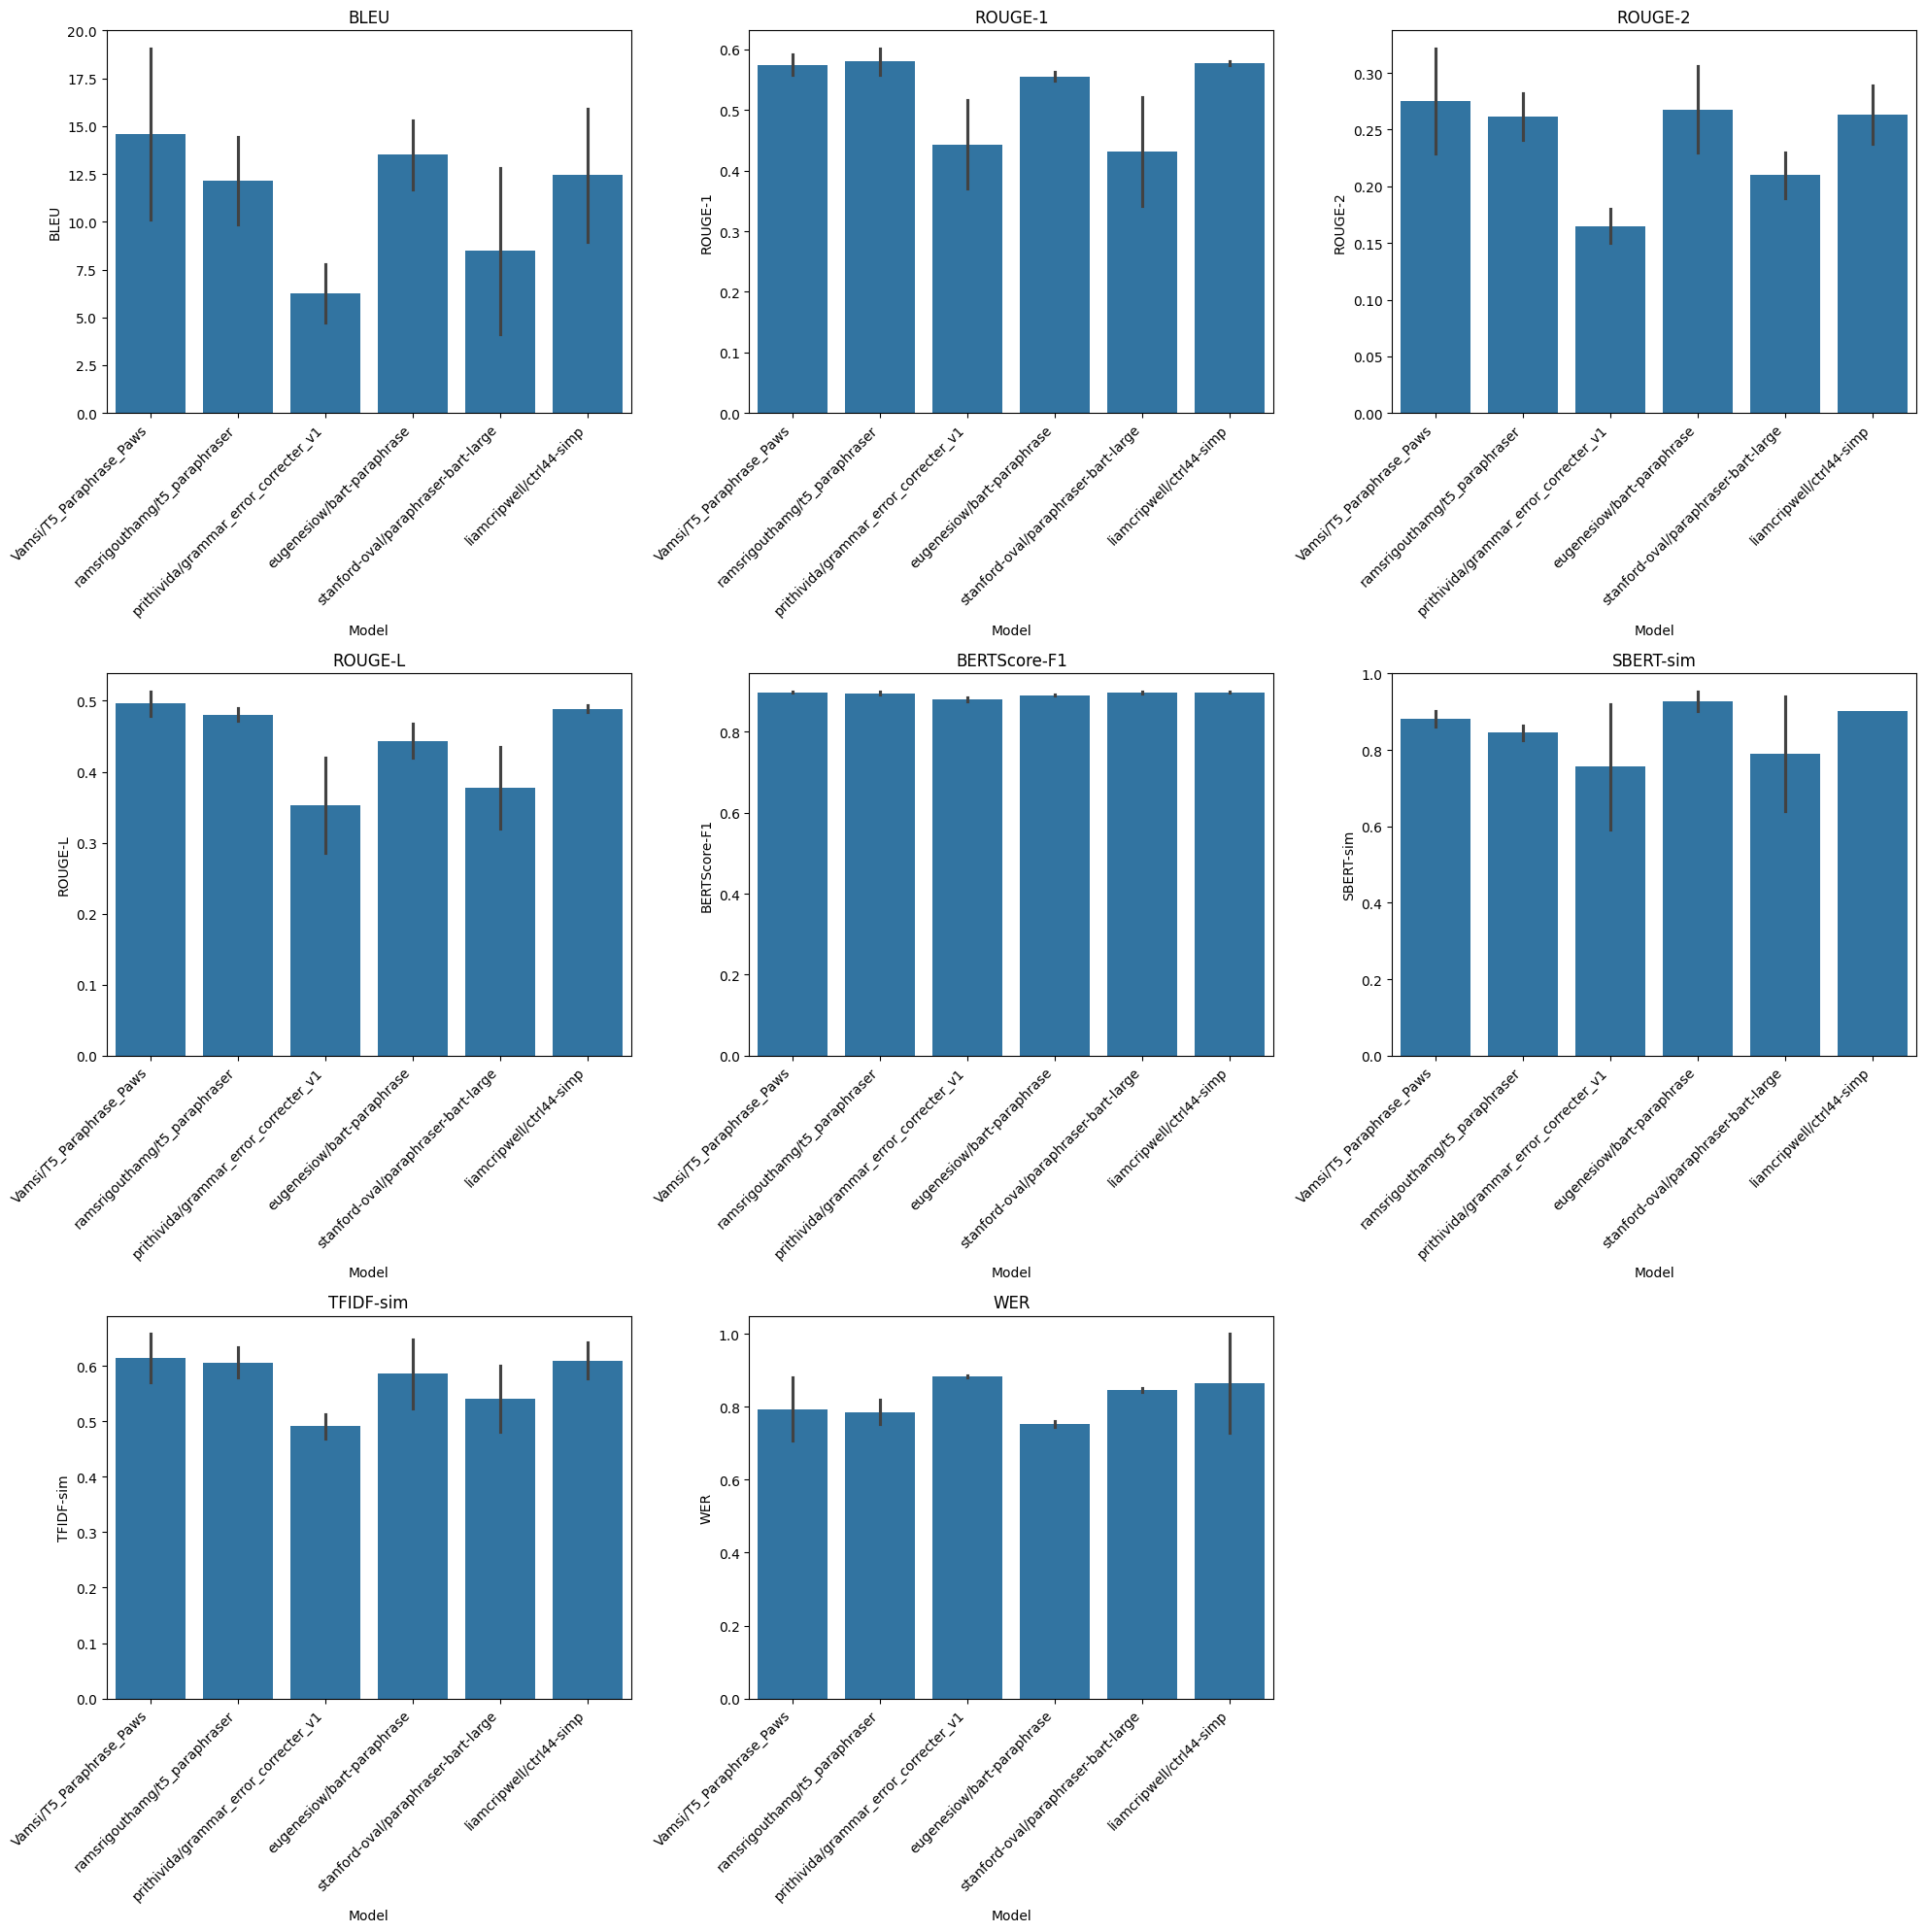

In [10]:
import os
import json
import numpy as np
import pandas as pd
import torch
import sacrebleu
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from jiwer import wer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
rouge = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

def evaluate_pair(pred, ref):
    # BLEU
    bleu = sacrebleu.sentence_bleu(pred, [ref]).score
    # ROUGE
    rs = rouge.score(ref, pred)
    r1, r2, rl = rs['rouge1'].fmeasure, rs['rouge2'].fmeasure, rs['rougeL'].fmeasure
    # BERTScore
    P, R, F1 = bert_score([pred], [ref], lang='en', verbose=False)
    b1 = F1.mean().item()
    # SBERT sim
    embs_p = sbert_model.encode(pred, convert_to_tensor=True)
    embs_r = sbert_model.encode(ref, convert_to_tensor=True)
    sim = util.pytorch_cos_sim(embs_p, embs_r).item()
    # WER
    w = wer(ref, pred)
    # TF-IDF sim
    tfidf = TfidfVectorizer().fit_transform([pred, ref])
    tf_sim = cosine_similarity(tfidf[0], tfidf[1])[0][0]
    return {
        'BLEU': bleu,
        'ROUGE-1': r1,
        'ROUGE-2': r2,
        'ROUGE-L': rl,
        'BERTScore-F1': b1,
        'SBERT-sim': sim,
        'WER': w,
        'TFIDF-sim': tf_sim
    }

# --- 4) Collect all scores into a DataFrame ---
records = []
for text_name, models_dict in results.items():
    ref = ground_truth[text_name]
    for model_name, pred in models_dict.items():
        scores = evaluate_pair(pred, ref)
        scores.update({'Text': text_name, 'Model': model_name})
        records.append(scores)
df = pd.DataFrame.from_records(records)

# --- 5) Display DataFrame ---
print(df)

# --- 6) Visualization ---
metrics = [
    'BLEU',
    'ROUGE-1',
    'ROUGE-2',
    'ROUGE-L',
    'BERTScore-F1',
    'SBERT-sim',
    'TFIDF-sim',
    'WER'
]
plt.figure(figsize=(20, 20))
for i, m in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.barplot(data=df, x='Model', y=m)
    plt.xticks(rotation=45, ha='right')
    plt.title(m)
plt.tight_layout()
plt.show()

table = (                          # aggregate over the two texts
    df.groupby('Model')[metrics]   # keep only the metric columns
      .mean()                      # mean across Text = rows
      .round(2)                    # prettier numbers
)

table.to_latex(
    "tables/sota_metrics.tex",
    float_format="%.2f",
    caption="Metric scores for the six Transformer baselines.",
    label="tab:sota-metrics"
)

In [11]:
# save the reformed texts for each model in a tex file
with open("tables/reformed_texts.tex", "w") as f:
    for text_name, models_dict in results.items():
        f.write(f"\\section*{{{text_name}}}\n")
        for model_name, pred in models_dict.items():
            f.write(f"\\subsection*{{{model_name}}}\n")
            f.write(pred + "\n\n")
            
# 

## Background: Embeddings, PCA, and t-SNE

### 1. Sentence Embeddings  
Given a sentence $s$, an embedding model (e.g. a Sentence-Transformer) maps $s$ to a vector  
$$
\mathbf{x} = f(s)\in \mathbb{R}^d
$$  
where $d$ is the embedding dimension. These vectors are trained so that semantically similar sentences satisfy  
$$
\lVert \mathbf{x}_i - \mathbf{x}_j\rVert_2 \text{ small}
$$  
and dissimilar ones are farther apart.

---

### 2. Principal Component Analysis (PCA)  
PCA finds an orthonormal basis $\{ \mathbf{u}_1,\dots,\mathbf{u}_k\}$ ($k=2$ for 2D) that maximizes variance:

1. Compute data matrix $X\in\mathbb{R}^{N\times d}$ by stacking $N$ embeddings.
2. Center: $\bar X = X - \mathbf{1}\mu^\top$, with $\mu = \tfrac1N\sum_i X_{i:}$.
3. Compute covariance $C = \tfrac1N \bar X^\top \bar X$.
4. Eigen-decompose:  
   $$
   C\,\mathbf{u}_i = \lambda_i\,\mathbf{u}_i,\quad \lambda_1 \ge \lambda_2 \ge \dots
   $$
5. Project onto top-2 components:  
   $$
   Y = \bar X\, [\mathbf{u}_1,\mathbf{u}_2] \quad\in \mathbb{R}^{N\times2}.
   $$

In the scatter plot, each point $Y_i$ shows the largest-variance directions of the original embeddings.

---

### 3. t-Distributed Stochastic Neighbor Embedding (t-SNE)  
t-SNE emphasizes local structure by modeling pairwise similarities in high- and low-dimensional spaces:

1. **High-dimensional affinities**  
   $$
   p_{j|i} = \frac{\exp\!\bigl(-\|\mathbf{x}_i-\mathbf{x}_j\|^2 /2\sigma_i^2\bigr)}{\sum_{k\neq i}\exp\!\bigl(-\|\mathbf{x}_i-\mathbf{x}_k\|^2 /2\sigma_i^2\bigr)},
   $$
   and symmetrize:  
   $$
   p_{ij} = \frac{p_{i|j} + p_{j|i}}{2N}.
   $$

2. **Low-dimensional affinities**  
   For mapped points $\mathbf{y}_i\in\mathbb{R}^2$:  
   $$
   q_{ij} = \frac{\bigl(1 + \|\mathbf{y}_i-\mathbf{y}_j\|^2\bigr)^{-1}}{\sum_{k\neq \ell}\bigl(1 + \|\mathbf{y}_k-\mathbf{y}_\ell\|^2\bigr)^{-1}}.
   $$

3. **KL-divergence objective**  
   Minimize  
   $$
   C = \sum_{i\neq j} p_{ij}\,\log\frac{p_{ij}}{q_{ij}}
   $$
   via gradient descent to position $\{\mathbf{y}_i\}$ so that local neighborhoods in $\mathbf{x}$-space are preserved in $\mathbf{y}$-space.

---

### Summary

- **Embeddings** convert sentences/texts into dense vectors where distances reflect semantics.  
- **PCA** gives a linear, variance-maximizing projection—good for global structure.  
- **t-SNE** yields a nonlinear, neighborhood-preserving map—highlighting clusters and local relationships.  
- Together, they help visualize how reconstruction pipelines shift meaning in high-dimensional semantic space.


In [12]:
# Group homemade (sentence-level) reconstructions
homemade = {
    "RNN_vocab": [vocab_rnn_plain_1, vocab_rnn_plain_2],
    "RNN_enron": [enronsent_rnn_plain_1, enronsent_rnn_plain_2],
    "WaitK_vocab": [vocab_rnn_wait_1, vocab_rnn_wait_2],
    "WaitK_enron": [enronsent_rnn_wait_1, enronsent_rnn_wait_2], 
    "Naive": [naive_reconstructed_1, naive_reconstructed_2]
}

off_shelf = {}
for text_name, model_dict in results.items():
    for model_name, recon_text in model_dict.items():
        # use a combined key for clarity
        key = f"{text_name}_{model_name}"
        # wrap each full-text reconstruction in a list to align shape with homemade
        off_shelf[key] = [recon_text]
        
        
# Embed all reconstructions using a sentence transformer
from sentence_transformers import SentenceTransformer
import numpy as np

embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for homemade (list of two sentences each)
homemade_emb = {
    name: [embed_model.encode(sent_list[0]), embed_model.encode(sent_list[1])]
    for name, sent_list in homemade.items()
}

# Compute embeddings for off-the-shelf (single full-text per key)
off_shelf_emb = {
    name: [embed_model.encode(text)]  # list with 1 element
    for name, texts in off_shelf.items() for text in texts
}

# Combine both
all_emb = {**homemade_emb, **off_shelf_emb}

# Prepare `reconstructed_embeddings` list: one array per reconstruction step
# Each homemade_emb[name] is [emb_step1, emb_step2]
# Each off_shelf_emb[name] is [emb_step1]
reconstructed_embeddings = []
for pipeline_name, emb_list in all_emb.items():
    # emb_list is a list of np.ndarrays per step
    # Stack them if there are multiple sentences per step
    for emb in emb_list:
        if emb.ndim == 1:
            reconstructed_embeddings.append(emb[np.newaxis, :])
        else:
            reconstructed_embeddings.append(np.atleast_2d(emb))

## Visualizing Embedding Displacements

With `reconstructed_embeddings` now compiled, we use PCA and t-SNE to map semantic shifts across reconstruction steps. Each point represents one sentence (or full text) reconstruction.

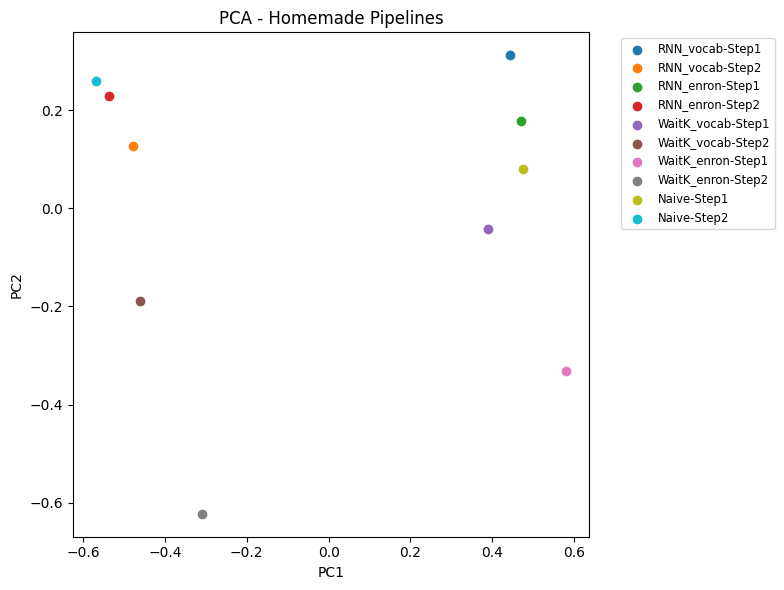

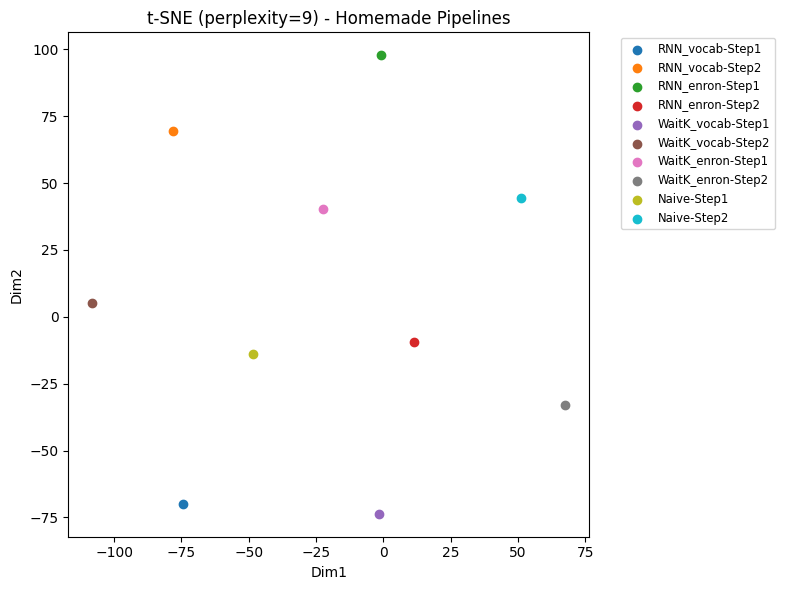

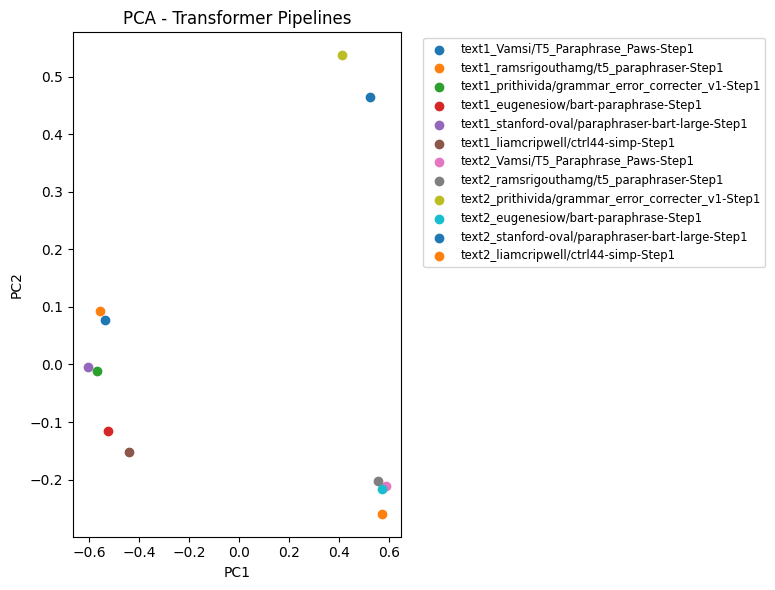

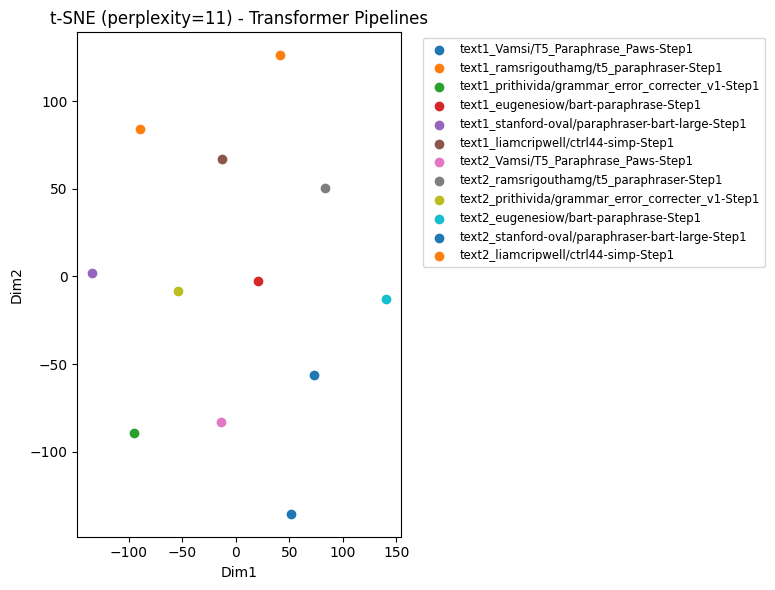

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Helper to visualize a category with dynamic perplexity
def visualize_category(emb_dict, category_name):
    # Flatten embeddings and labels
    all_embeds = []
    labels = []
    for pipeline, steps in emb_dict.items():
        for step_idx, emb in enumerate(steps, start=1):
            mat = emb if emb.ndim == 2 else emb[np.newaxis, :]
            all_embeds.append(mat)
            labels.append(f"{pipeline}-Step{step_idx}")
    # Stack into X
    X = np.vstack(all_embeds)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,6))
    for i, label in enumerate(labels):
        plt.scatter(X_pca[i,0], X_pca[i,1], label=label)
    plt.title(f"PCA - {category_name}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

    # t-SNE with dynamic perplexity
    n_samples = X.shape[0]
    perp = min(30, n_samples - 1)
    tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=perp)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8,6))
    for i, label in enumerate(labels):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], label=label)
    plt.title(f"t-SNE (perplexity={perp}) - {category_name}")
    plt.xlabel("Dim1")
    plt.ylabel("Dim2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

# Run for each category
visualize_category(homemade_emb, "Homemade Pipelines")
visualize_category(off_shelf_emb, "Transformer Pipelines")

## Interpretation of Visualization Results

### Homemade Pipelines

- **PCA Plot**:  
  The two reconstruction steps for each homemade pipeline cluster closely, indicating that sentence-level reconstructions maintain a similar semantic space. However, RNN-based models (`RNN_vocab`, `RNN_enron`) show a noticeable displacement between step 1 and step 2, suggesting incremental semantic drift as additional context is incorporated. The `WaitK` variants and `Naive` approach exhibit smaller shifts, reflecting more conservative changes in meaning.

- **t-SNE Plot**:  
  With a perplexity appropriate to the small sample size, t-SNE amplifies local neighborhood structure. `RNN_enron` and `WaitK_enron` step-2 points move further away from their step-1 counterparts compared to the `vocab` variants, hinting that on more complex (Enron) sentences, these models alter semantics more dramatically.

### Transformer Pipelines

- **PCA Plot**:  
  All transformer reconstructions (one per model) appear spread out along PC1 and PC2, indicating diverse paraphrase or correction strategies. Models like `prithivida/grammar_error_correcter_v1` and `ramsrigouthamg/t5_paraphraser` produce outputs quite distant from the raw texts, whereas simplification-focused models (`liamcripwell/ctrl44-simp`) lie closer to the original embedding.

- **t-SNE Plot**:  
  The larger sample count allows t-SNE to reveal sub-clusters by text source. `text2_…` points form a loose cluster distinct from `text1_…`, showing that the content of the input text strongly influences the embedding transformations. Within each text group, certain models (e.g., `stanford-oval/paraphraser-bart-large`) remain centrally located—suggesting semantic fidelity—while others (e.g., `ramsrigouthamg/t5_paraphraser`) take more liberties.

### Overall Insights

- Homemade pipelines yield small, incremental shifts per reconstruction step, as expected for models operating on sentence fragments.  
- Off-the-shelf transformers exhibit larger, model-dependent displacements, reflecting varied paraphrasing and simplification objectives.  
- t-SNE highlights text-specific grouping that PCA may smooth over, making it useful for identifying which models preserve content versus those that diverge most.

These visualizations confirm that semantic drift varies by model type, reconstruction step, and source text complexity. Use these insights to select or further tune pipelines according to how conservatively or aggressively you want meaning to change.
